# ECE 9309/9039 Assignment 1 Winter 2023

# Total: /100

## Instructions

* Complete the Lab assignment

* Once the notebook is complete, restart your kernel and rerun your cells

* Submit this notebook to owl by the deadline

* You may use any python library functions you wish to complete the Lab assignment.



This notebook contains the questions for Assignment 1. Please note, a random seed has been set to ensure the reproducability of the results -- *DO NOT* change this random seed. **If you call additional functions that are based on random number generators, you will need to define their seed to 42 as well**. Make sure to complete this assignment individually and appropriately reference all external code and documentation used. 

In [31]:
import matplotlib
import matplotlib.pyplot as plt 
%matplotlib inline
import pandas as pd 
import numpy as np
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Lasso, Ridge, LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.metrics import make_scorer, mean_absolute_error, r2_score, accuracy_score, precision_score

np.random.seed(42)

## Data set 

This assignment's objective is to develop a data-driven predictive model for the power consumption of an industrial refrigeration system using the `Data_Rack01` dataset.  
The data frame contains the following data, where each row represents a datapoint:

- Dew_Point: the temperature to which air must be cooled to become saturated with water vapor 
- Indoor_Humidity: The indoor Humidity
- Indoor_Temperature: The indoor temprature (Fahrenheit)
- Outdoor_Humidity: The outdoor humidity
- Outdoor_Temperature: The outdoor temprature (Fahrenheit)
- Discharge_Pressure: The pressure generated on the output side of a gas compressor in a refrigeration system
- Discharge_Temperature: The compressor's discharge temperature 
- KW: Power consumed
- Power_Factor: The power factor of the refrigeration system
- Volts_Line_to_Line
- Volts_Line_to_Neutral

## Question 1 (40 pts)

### a) Preprocess the data acording to the following:

1. Load data into a variable called myData
2. In the `myPreProc` function perform the following:
  - Remove the empty column(s), 
  - Drop rows with any missing data ("NA").
  - Remove the 'DeviceName' column as well

The processed data should be returned through the function variable `procData`

### b) Define two loss functions:
- one that measures the absolute difference between observations and predictions. Return mean and standard deviation of the result.
- one that finds the absolute difference that is less than or equal to a threshold. Return mean and standard deviation of the result.

### c) Data splitting:
- Use power consumption as the target variable for your machine learning model. 
- Split your preprocessed dataset by setting aside some amount of data for testing, and retaining the rest for training. Reserve 30 percent of your data for testing. *Make sure to set the random_state to 42 if you are using an sklearn function to accomplish this. 


### d) Build a linear regression model:
- Using Ordinary Least Squares, build a model to predict power consumed (KW) as a `linear function` of the other variables (features) in the dataset. In order to properly build the regression model, the features need to be standardized so that no feature can dominate others in determining the prediction values due to differences in feature scales. Build the pipeline that standardizes the features and creates a linear regression model.
- Report the coefficient of determination (`R2 score`) when evaluating both the training and testing performance of your model.

In [32]:
#Part 1a

#load data
myData = pd.read_csv('Data_Rack01.csv')
#myData.info()
def myPreProc(data):

    procData= data.dropna(how='all', axis=1)
    procData= procData.dropna(how='any', axis=0)
    procData= procData.drop( columns='DeviceName')

   #write function
    return procData

myData=myPreProc(myData)
myData.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 25751 entries, 0 to 25750
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Dew_Point              25751 non-null  float64
 1   Indoor_Humidity        25751 non-null  float64
 2   Indoor_Temperature     25751 non-null  float64
 3   Outdoor_Humidity       25751 non-null  float64
 4   Outdoor_Temperature    25751 non-null  float64
 5   Discharge_Temperature  25751 non-null  float64
 6   kW                     25751 non-null  float64
 7   Power_Factor           25751 non-null  float64
 8   Volts_Line_to_Line     25751 non-null  float64
 9   Volts_Line_to_Neutral  25751 non-null  float64
dtypes: float64(10)
memory usage: 2.2 MB


In [33]:
#Part 1b

def abs_diff_loss(obs, pred):
    
    #write function
    resids= np.abs(obs -pred)
    return resids.mean(), resids.std(ddof=1)
    
def threshold_loss(obs, pred, thresh):
    absDiff=np.abs(obs -pred)
    resids = absDiff[absDiff <= thresh]
    #write function
    
    return resids.mean(), resids.std(ddof=1)



In [34]:
#Part 1c
X = myData.drop('kW', axis = 1)
Y = myData['kW']

# Split the data into training and testing sets
X_train, X_test, Y_train, Y_test= train_test_split(X, Y, test_size=0.3, random_state=42)



In [35]:
#Part 1d
import time
# Create the pipeline
pipe = Pipeline([('scaler', StandardScaler()), 
                 ('regressor', LinearRegression())
                 ])

start_time = time.time()

# Fit the pipeline on the training data
pipe.fit(X_train, Y_train)

end_time = time.time()
execution_time = end_time - start_time

# Predict the target values  on the training and testing data
y_train_predict = pipe.predict(X_train)
y_test_predict=  pipe.predict(X_test)

#calculate R2 score
train_r2= r2_score(Y_train,y_train_predict)
test_r2= r2_score(Y_test,y_test_predict)

print("Training R2 score: {:.2f}".format(train_r2))
print("Testing R2 score: {:.2f}".format(test_r2))
print("execution_time: {:.2f}".format(execution_time))

Training R2 score: 0.44
Testing R2 score: 0.42
execution_time: 0.02


## Question 2 - Regularization (25 pts) 

- Use L2 regularization by adding a penalty of $\lambda \sum_{i}{\beta_i^2}$ (where $\beta_i$ are your regression coefficients) to the regression model. Vary the regularization parameter  𝜆  between 0.2 and 250, evenly spaced in log-space, and generate 50 values.
- Build the pipeline that standardizes the features and create a regularized regression model.
- Determine the 10-fold crossvalidated performance for different values of the L2-regularisation parameters. Use the cross-validated log-likelihood of the data under the model as evaluation criterion.  
- Make a plot of the crossvalidated log-likelihood against $log(\lambda)$. 
- Report the best lambda that you found

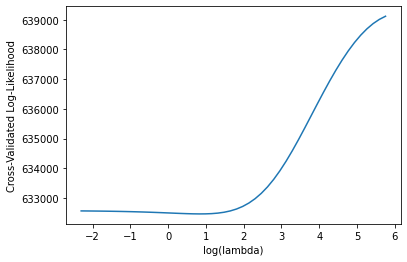

Best lambda:  2.2758459260747874


In [36]:
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import make_scorer

# generate 50 values of lambda evenly spaced in log-space
lambda_values = np.logspace(-1, 2.5, 50)

# Pipeline that standardizes the features and creates a Ridge model
model = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', Ridge())
])


cv = KFold(n_splits=10, shuffle=True, random_state=42)

def log_likelihood(y_true, y_pred):
    sigma=1
    return -0.5 * np.sum((y_true - y_pred) ** 2 / sigma ** 2 + np.log(2 * np.pi * sigma ** 2))

# Define the custom scoring function using the log_likelihood function
sigma = 1
log_likelihood_scorer = make_scorer(log_likelihood, greater_is_better=True, needs_proba=False, needs_threshold=False)

scores = []
for l in lambda_values:
    model.set_params(regressor__alpha=l)
    scores.append(-np.mean(cross_val_score(model, X, Y, cv=10, scoring=log_likelihood_scorer)))

# plotting cross-validated log-likelihood against log(lambda)
plt.plot(np.log(lambda_values), scores)
plt.xlabel('log(lambda)')
plt.ylabel('Cross-Validated Log-Likelihood')
plt.show()


# BEST lambda value
best_lambda = lambda_values[np.argmin(scores)]
print('Best lambda: ', best_lambda)


## Question 3 - Classification (35 pts)

### a) Binary target:
- Convert your target variable in the dataset into a binary variable using >= mean thresholding (use the same data splitting as before). 

### b) Build logistic regression model:
- Define a Logistic Regression model and report the resulting *training* precision and *testing* accuracy of your model. Make sure the set the maximum number of iterations for your model to 10000 (use pipeline for normalization and model building same as Questions 1 and 2).

### c) Build a Support Vector Machine (SVM) model:
- Define a linear SVM model with default options and maximum number of iterations 10000. Report the resulting *training* precision and *testing* accuracy of your model (use pipeline for normalization and model building same as Questions 1 and 2).


### d) Comparison:
- Compare the performance of your models in `b` and `c` in terms of generalization performance and execution time, what do you conclude? 

In [37]:
#Part 3a
meanThreshold = np.mean(Y)
y_bin = np.where(Y >=meanThreshold, 1, 0 )

In [38]:
#Part 3b
X_train, X_test, Y_train, Y_test= train_test_split(X, y_bin, test_size=0.3, random_state=42)

lr_pipeline =  Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', LogisticRegression(solver='lbfgs', max_iter=10000))
])

start_time = time.time()

# Fit the pipeline on the training data
lr_pipeline.fit(X_train, Y_train)

end_time = time.time()
execution_time = end_time - start_time




# Evaluate the model performance
train_precision = precision_score(Y_train, lr_pipeline.predict(X_train))
test_accuracy = accuracy_score(Y_test, lr_pipeline.predict(X_test))


print("Training precision: ", train_precision)
print("Testing accuracy: ", test_accuracy)
print("execution_time: {:.2f}".format(execution_time))

Training precision:  0.807841483979764
Testing accuracy:  0.8045560445249806
execution_time: 0.12


In [39]:
#Part 3c

X_train, X_test, Y_train, Y_test= train_test_split(X, y_bin, test_size=0.3, random_state=42)

svm_pipeline =  Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', LinearSVC( max_iter=10000))
])

start_time = time.time()

svm_pipeline.fit(X_train, Y_train)


end_time = time.time()
execution_time = end_time - start_time

# Evaluate the model performance
train_precision = precision_score(Y_train, svm_pipeline.predict(X_train))
test_accuracy = accuracy_score(Y_test, svm_pipeline.predict(X_test))


print("Training precision: ", train_precision)
print("Testing accuracy: ", test_accuracy)
print("execution_time: {:.2f}".format(execution_time))



Training precision:  0.7866311455558247
Testing accuracy:  0.7912244369660886
execution_time: 14.87


/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


*Part 3d*

`Written Answer:`

Conclusion:

**Logistic Regression**
Training precision:  0.807841483979764
Testing accuracy:  0.8045560445249806

**Support Vector Machine**
Training precision:  0.7866311455558247
Testing accuracy:  0.7912244369660886


It can be seen that Logistic regression performs better in comparison to SVM as it has around **80% of training precision and testing accuracy**. Also it's execution time is just **0.12** secs, which is musch lesser than the execution time of SVM (14.87 secs).

So we can conclude that Logistic Regression performs better among both.